# Integrantes:
- Jorge Eduardo Rodriguez Cardozo - 200711501
- German Augusto Carvajal Murcia -  201313516

# Exercise 06
# TensorFlow and Keras


---

In [1]:
import numpy as np
import pylab as pl
from sklearn.datasets.samples_generator import make_moons

%matplotlib inline

# Functions for plotting 2D data and decision regions

def plot_data(X, y,title='Data'):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title(title)

def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 30)
    y_vals = np.linspace(min_y, max_y, 30)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 30, cmap = pl.cm.coolwarm, vmin= 0, vmax=1)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")

### 1. Multilayer neural network in TensorFlow

You need to create a neural network model in TF that is able to discriminate the two classes in the following dataset:

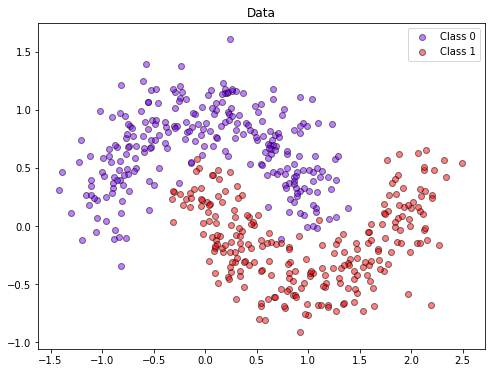

In [2]:
X, Y = make_moons(n_samples=1000, noise= 0.2, random_state=3)
x_train = X[:500]
x_test  = X[500:]
y_train = Y[:500]
y_test  = Y[500:]

pl.figure(figsize=(8, 6))
plot_data(x_train, y_train)

For this you will need to create a neural network with one hidden layer. You cannot use prebuilt models 
such as those in `tf.estimator`. **Hint**: extend the logistic regression example from the TensorFlow handout. 

Your answer must contain the following:
* A visualization of the CG of the model.
* A visualization of the decision region along with the test data.
* A snapshot from TensorBoard that shows the evolution of the training and test loss.

In [3]:
import tensorflow as tf
from IPython.display import clear_output, Image, display, HTML

%matplotlib inline


# Helper functions to inline visualization of computing graphs
# Extracted from: 
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1000px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
    
def variable_summaries(var,name):
    with tf.name_scope(name):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [4]:
graph = tf.Graph()
n_hidden = 40
learning_rate = 1
seed = 123

with graph.as_default():
    
    tf.set_random_seed(seed)
    x = tf.placeholder(tf.float32,shape=[None,2],name='Features')
    y_true = tf.placeholder(tf.float32,shape=[None,1],name='Class')
    
    with tf.name_scope('hidden') as scope:
        w1 = tf.Variable(tf.random_normal([2, n_hidden]),dtype=tf.float32,name='weights1')
        b1 = tf.Variable(tf.random_normal([n_hidden]),dtype=tf.float32,name='bias1')
        layer = tf.add(tf.matmul(x,w1),b1)
        layer=tf.sigmoid(layer,name='activation')
        variable_summaries(w1,name='Sum_w1')
        variable_summaries(b1,name='Sum_b1')
        
    with tf.name_scope('out') as scope:
        w2 = tf.Variable(tf.random_normal([n_hidden, 1]),dtype=tf.float32,name='weights2')
        b2 = tf.Variable(tf.random_normal([1]),dtype=tf.float32,name='bias2')
        y_pred = tf.add(tf.matmul(layer,w2),b2)
        variable_summaries(w2,name='Sum_w2')
        variable_summaries(b2,name='Sum_b2')

    with tf.name_scope('loss') as scope:
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true,logits=y_pred)
        loss = tf.reduce_mean(loss)
        variable_summaries(loss,name='Loss')
  
    with tf.name_scope('train') as scope:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        train = optimizer.minimize(loss)

    merged = tf.summary.merge_all()
    init = tf.global_variables_initializer()

## CG model visualization

In [5]:
show_graph(graph.as_graph_def())

In [6]:
import os
os.chdir('/Users/germancarvajal/Desktop')

In [7]:
LOG_DIR = 'logs'
train_writer = tf.summary.FileWriter(LOG_DIR + '/train', graph=graph)
test_writer = tf.summary.FileWriter(LOG_DIR + '/test')

num_epochs = 1000
lossesTr = []
lossesTs = []

with graph.as_default():
    sess = tf.Session()
    sess.run(init)      
    for step in range(num_epochs):
        summary, train_loss, _ = sess.run([merged, loss, train] ,{x: x_train, y_true: y_train.reshape(-1,1)})
        train_writer.add_summary(summary, step)
        summary, val_loss = sess.run([merged, loss] ,{x: x_test, y_true: y_test.reshape(-1,1)})
        test_writer.add_summary(summary, step)
        if step % 10 == 0:
            # print(step, train_loss, val_loss)
            lossesTr.append(train_loss)
            lossesTs.append(val_loss)

(0, 2.0)

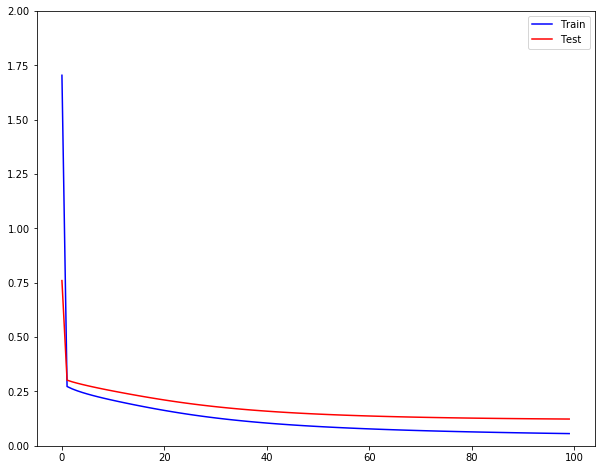

In [8]:
pl.figure(figsize = (10,8))
pl.plot(lossesTr, '-b',label='Train')
pl.plot(lossesTs, '-r',label='Test')
pl.legend(loc='upper right')
pl.ylim(0, 2.0)

In [9]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

## Decision region and test data

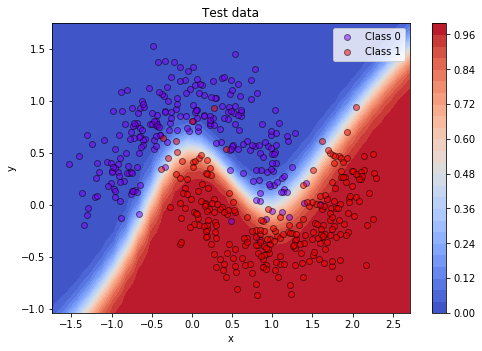

In [10]:
with graph.as_default():
    def pred_fun(x1, x2):
        xval = np.array([[x1, x2]])
        return sigmoid(sess.run(y_pred,{x: xval}))

pl.figure(figsize = (8,16/3))    
plot_decision_region(X, pred_fun)
plot_data(x_test, y_test,title='Test data')

## TensorBoard evolution of training and test loss

<img width=1000 src="images/TensorBoard.png" align="middle">

### 2. Improving the Keras text classifier

Your goal is to improve the performance of the text classifier in the Keras handout. This is are the things that you need to try:

* Different activation functions for the hidden layer (https://keras.io/activations/)
* Different optimizers (https://keras.io/optimizers/)
* Add dropout between the hidden layer and the output layer (https://keras.io/layers/core/#dropout)
* Different initializers for the dense layers (https://keras.io/initializers/)

Try different combinations and report your findings at the end. Which configuration got the best accuracy in test?


**Solution**

In order to ensure the different calibrated models are comparable between them, all the data preparation steps are performed beforehand. By doing this, the train and test datasets will be the same across the different optimization, and architectural neural networks trained. Also, the randomness of all processes is controled be seeding all sources of variability, thus the score results can only be affected by the parameters optimization.

In [11]:
import keras
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.datasets import reuters
from keras.preprocessing.text import Tokenizer
max_words = 1000
np.random.seed(123)
tokenizer = Tokenizer(num_words=max_words)
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_words, test_split=0.2)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
num_classes = np.max(y_train) + 1
print(num_classes, 'classes')
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
y_train = keras.utils.to_categorical(y_train, num_classes)
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')
y_test = keras.utils.to_categorical(y_test, num_classes)
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

Using TensorFlow backend.


8982 train sequences
2246 test sequences
46 classes
x_train shape: (8982, 1000)
y_train shape: (8982, 46)
x_test shape: (2246, 1000)
y_test shape: (2246, 46)


To improve the performance of the text classifier we'll explore the 4 most popular activation functions, 3 different optimizers including the stochastic-gradient descent and ADAM. The dropout will be explored from no-dropout to 90% left out of the network, and 3 different initialization strategies with two stochastic approaches and a standard 0 kernel. All posible combinations of architecture are trained and evaluated over the same samples to check their performance, for a total of 144 neural netowrks trained and evaluated.

In [12]:
activations=['softmax','relu','tanh','sigmoid']
optim=['sgd','rmsprop','adam']
drop=np.linspace(0,0.9,4)
initi=['zeros','RandomNormal','RandomUniform']
total=len(activations)*len(optim)*len(drop)*len(initi)

The following visualization function is defined to better of the progress supervision of the training and evaluation of the neural networks over the extensive posibilities set.

In [ ]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()

All the set of pobible combinations of parameters is explored through the following 4 loop-in-loop algorithm. The evaluation results for every posibility are stored in the `'resultados'` array for later performance analysis and selection of the best performing model.

In [14]:
resultados=[]
n=0
for a in activations:
    for o in optim:
        for d in drop:
            for i in initi:
                n=n+1
                np.random.seed(123)
                tf.set_random_seed(123)
                model = Sequential()
                model.add(Dense(256, input_shape=(max_words,),kernel_initializer=i))
                model.add(Activation(a))
                model.add(Dropout(d,seed=123))
                model.add(Dense(num_classes,kernel_initializer=i))
                model.add(Activation('softmax'))
                model.compile(loss='categorical_crossentropy',optimizer=o,metrics=['accuracy'])
                model.fit(x_train, y_train,batch_size=32,epochs=5,verbose=0,validation_split=0.1)
                score = model.evaluate(x_test, y_test,verbose=0)
                resultados.append([a,o,d,i,score[0],score[1]])
                printProgressBar(n,total,prefix = 'Progress:', suffix = 'Complete', length = 50)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [16]:
import pandas as pd
results=pd.DataFrame(resultados,columns=['Hidden_activation','Optimizer','Dropout','Initializer','Test score','Test accuracy'])

As it can be seen in the following table, the best accuracy for the text classifier was achieved in 4 out of the best 5 cases by using the hyperbolic tangent function. The best optimizers according to the list were ADAM and RMSprop, both improving the performance of the SGD algorithm. The initializalization strategy appears to have some influence over the results, all the top 5 having a random start values for the iterations. Most notably, the dropout values for the best 5 cases ranges between 0 (no-dropout) and 60% in 3 of the explored combinations.

In summary, the best performing combination using the same number of epochs, batch sizes, layers and neurons as the original model on handout 11 was the one with the following specification:

- Hidden layer activation function: TANH
- Optimizer: ADAM
- Dropout: 60%
- Initializer: Random Uniform

This combination lead to an accuracy of 0.8, a big leap over the approximate 0.5 achived by the original formulation. As this two models share the same architecture, then is obvios how the training process can alter the results of neural network models.

In [17]:
results.nlargest(5,'Test accuracy')

,Hidden_activation,Optimizer,Dropout,Initializer,Test score,Test accuracy
104,tanh,adam,0.6,RandomUniform,0.842288,0.800089
86,tanh,rmsprop,0.0,RandomUniform,0.892876,0.798308
68,relu,adam,0.6,RandomUniform,0.858919,0.797418
89,tanh,rmsprop,0.3,RandomUniform,0.874468,0.796972
91,tanh,rmsprop,0.6,RandomNormal,0.891012,0.796972
